In [210]:
import numpy as np
import os
from astropy import wcs
from astropy.io import fits
from matplotlib import pyplot as plt 
from astropy import units as u
from photutils import DAOStarFinder
from astropy.io import fits
from astropy.visualization import *
from astropy.stats import mad_std
from astrofyp_functions import *
from astroquery.vizier import Vizier
from astropy.coordinates import Angle
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from astropy import units as u
Vizier.ROW_LIMIT = -1

In [211]:
# --- Plot Parameters ---- 
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["figure.dpi"] = 100
# plt.rc('font', family = 'serif', serif = 'cmr10') 
# plt.rcParams.update({# Use mathtext, not LaTeX
#                             'text.usetex': True,
#                             # Use the Computer modern font
#                             'font.family': 'serif',
#                             'font.serif': 'cmr10',
#                             'mathtext.fontset': 'cm',
#                             })
plt.rcParams.update({'font.size': 22})
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
colour_arrays = ['red', 'blue', 'green', 'crimson', 'lime']

# World Coordinate System Definition 

In [212]:
os.listdir('astrometric_obs_data/')

['berkeley28_B_wcs.fits',
 'berkeley28_V_wcs.fits',
 '.DS_Store',
 'NGC2324_V_wcs.fits',
 'NGC2355_B_wcs.fits',
 'NGC2355_V_wcs.fits',
 'NGC2325_B_wcs.fits',
 'Bochum2_V_wcs.fits',
 'Bochum2_B_wcs.fits']

In [251]:
temp_file_name = 'astrometric_obs_data/NGC2324_V_wcs.fits'
hdulist = fits.open(temp_file_name)
image_data = hdulist[0].data; print(np.shape(image_data))
tWCS = wcs.WCS(hdulist[0].header) #global variable
target_name = temp_file_name[21:-8]

(800, 850)


In [214]:
def starfinder(data, thrs, plot_cond):

    mst_std = mad_std(data)
    daofind = DAOStarFinder(fwhm = 6., threshold = thrs*mst_std)
    mst_sources = daofind(data)

    for col in mst_sources.colnames: 
        mst_sources[col].info.format = '%.8g'

    if plot_cond == True: 
        plt.scatter(mst_sources['xcentroid'], mst_sources['ycentroid'], facecolors='none', edgecolors='lime')
        for i in range(0, len(mst_sources)):
            plt.annotate((i + 1), xy = (mst_sources['xcentroid'][i], mst_sources['ycentroid'][i]), fontsize= 5)
        plt.imshow(data, vmin = data.mean() - data.std(), vmax = data.mean() + data.std(), cmap = 'gist_yarg'); plt.show()

    return mst_sources

## WCS Conversion 

In [215]:
def WCS_conversion(file_path):
    '''
    INPUT - .fits image for reading the WCS from the header, DAO Sources from a given image
    FUNCTION - Uses (x and y) centroid positions and the wcs to convert pixel values into RA and DEC (J2000)
    OUTPUT - An array of WCS values for each source in the fits file. where [n][0] - RA and [n][1] - DEC. And RA, DEC for centre-frame. 
    '''

    hdulist = fits.open(file_path)
    data = fits.getdata(file_path)

    DAO_sources  = starfinder(data, 6, True) # calling the star finder function 

    target_RADEC = []

    # Parse the WCS keywords in the primary HDU
    w = wcs.WCS(hdulist[0].header)

    for idx in range(0, len(DAO_sources)):
        world = w.pixel_to_world(DAO_sources['xcentroid'][idx], DAO_sources['ycentroid'][idx])
        target_RADEC.append(world)

    centre =  w.pixel_to_world(np.shape(data)[0]/2, np.shape(data)[1]/2)
    
    return target_RADEC, centre, DAO_sources

def Pixel_conversion(RA, DEC, file_path): 
    coords = SkyCoord(RA, DEC, unit = 'deg')
    
    hdulist = fits.open(file_path)
    w = wcs.WCS(hdulist[0].header)

    return w.world_to_pixel(coords)

def single_WCS_conversion(x_pix, y_pix, file_path): 
    hdulist = fits.open(file_path)
    w = wcs.WCS(hdulist[0].header)

    return w.pixel_to_world(x_pix, y_pix)


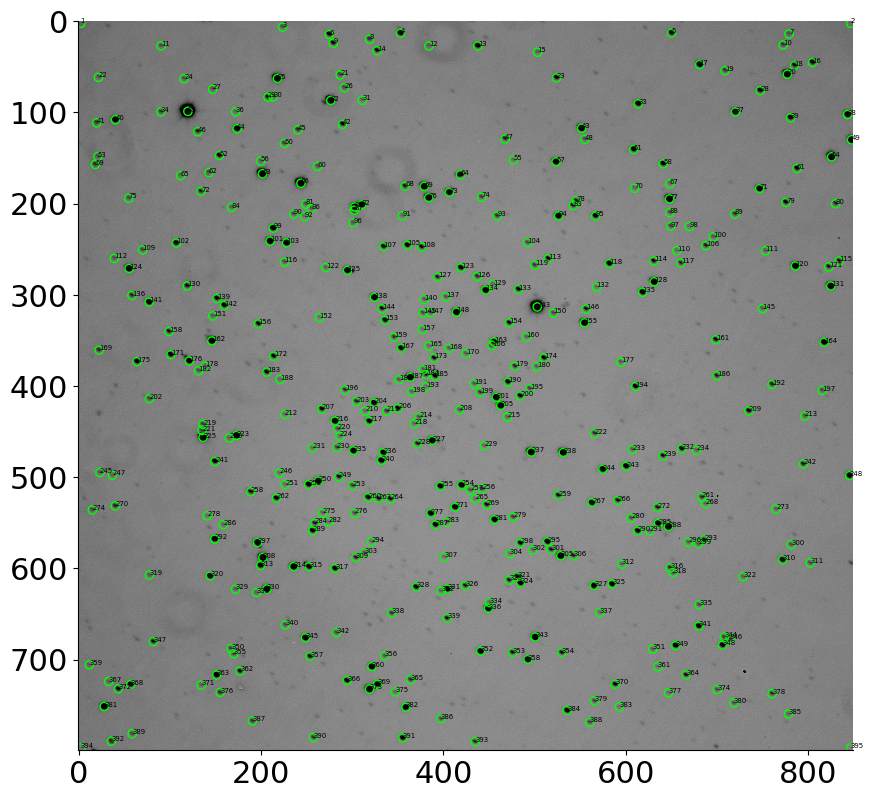

(395,)
<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (106.03228721, 1.04786894)>
<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (103.12101267, 3.01111063)>
0.10230024446697165


In [216]:
tar, cnt, DAO_source_table = WCS_conversion(temp_file_name)
edge = single_WCS_conversion(0, 0, temp_file_name)
sep = cnt.separation(edge).degree

In [217]:
def find_nearest(array, value):
    array = np.asarray(array); idx = (np.abs(array - value)).argmin()
    return array[idx], idx

In [232]:
def APASS_query(frame_center):
    edge = tWCS.pixel_to_world(0, 0)
    query_radius = frame_center.separation(edge).degree # returns seperation in correct unit. 
    print(query_radius)

    return(Vizier.query_region(coord.SkyCoord(frame_center, frame='fk5'), radius=Angle(query_radius, "deg"),  catalog='apass9')[0])

edge = tWCS.pixel_to_world(0, 0); max_ed = tWCS.pixel_to_world(850, 800)
print(max_ed, max)

catalog_result = APASS_query(cnt)
thrs = catalog_result['e_Vmag'].mean() + catalog_result['e_Vmag'].std()
# catalog_result = (catalog_result[np.where(catalog_result['DEJ2000'] > edge.dec.degree) and np.where(catalog_result['DEJ2000'] < max_ed.dec.degree)])
# and catalog_result[np.where(catalog_result['RAJ2000'] > edge.ra.degree) and np.where(catalog_result['RAJ2000'] < max_ed.ra.degree)]])

catalog_result = catalog_result[np.where(catalog_result['e_Vmag'] < thrs) and np.where(catalog_result['e_Vmag'] > 0)]
test_RA = catalog_result['RAJ2000']
test_DEC = catalog_result['DEJ2000']

catalog_result

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (105.95521176, 0.98203672)> <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (102.97582442, 2.86876024)>
0.10230024446697165


recno,RAJ2000,DEJ2000,e_RAJ2000,e_DEJ2000,Field,nobs,mobs,B-V,e_B-V,Vmag,e_Vmag,Bmag,e_Bmag,g_mag,e_g_mag,r_mag,e_r_mag,i_mag,e_i_mag
,deg,deg,arcsec,arcsec,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag
int32,float64,float64,float32,float32,int64,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
21947441,105.995965,0.955826,0.781,0.404,20140040,5,21,0.688,0.033,14.914,0.029,15.602,0.016,15.195,0.027,14.756,0.030,14.598,0.042
21947442,106.029437,0.951538,0.403,0.438,20110040,7,27,0.273,0.038,14.235,0.029,14.508,0.024,14.282,0.032,14.220,0.014,14.317,0.058
21947444,106.033922,0.963522,0.444,1.258,20140040,4,14,0.477,0.060,15.117,0.033,15.595,0.050,15.280,0.010,15.029,0.063,15.058,0.070
21947446,106.042052,0.948084,0.517,0.858,20140040,3,12,0.692,0.066,15.557,0.052,16.249,0.040,15.811,0.000,15.406,0.056,15.268,0.298
21947447,106.047499,0.963410,0.789,0.384,20140040,3,8,0.746,0.034,15.838,0.023,16.584,0.025,16.132,0.016,15.612,0.054,--,--
21947448,106.049458,0.955469,1.316,0.304,20140040,3,8,1.156,0.123,16.681,0.120,17.838,0.026,17.222,0.046,16.486,0.037,--,--
21947449,106.044951,0.969728,0.578,0.346,20110040,8,29,0.230,0.020,13.967,0.011,14.198,0.017,14.009,0.025,13.999,0.016,14.071,0.041
21947452,106.060260,0.980150,0.819,0.818,20140040,3,10,0.848,0.077,16.456,0.038,17.304,0.067,16.827,0.013,16.324,0.042,--,--


In [234]:
obs_index = []; cat_index = []

catalog_coord = SkyCoord(catalog_result['RAJ2000'], catalog_result['DEJ2000'], unit = 'deg')

obs_idx = 0; cat_idx = 0 
for obs_coord in tar:
    sep2tar = obs_coord.separation(catalog_coord).degree
    if sep2tar.min() < 10e-4:
        obs_index.append(obs_idx)
        cat_index.append(np.argmin(sep2tar))
    cat_idx += 1
    obs_idx += 1 

# complete removal of duplicates from the set 
res = [idx for idx, val in enumerate(cat_index) if val in cat_index[:idx]]

cat_index = np.delete(cat_index, res); obs_index = np.delete(obs_index, res)
res = np.array(res) - 1
cat_index = np.delete(cat_index, res); obs_index = np.delete(obs_index, res)


catalog_RA_pixel, catalog_DEC_pixel = Pixel_conversion(catalog_result['RAJ2000'], catalog_result['DEJ2000'], temp_file_name)

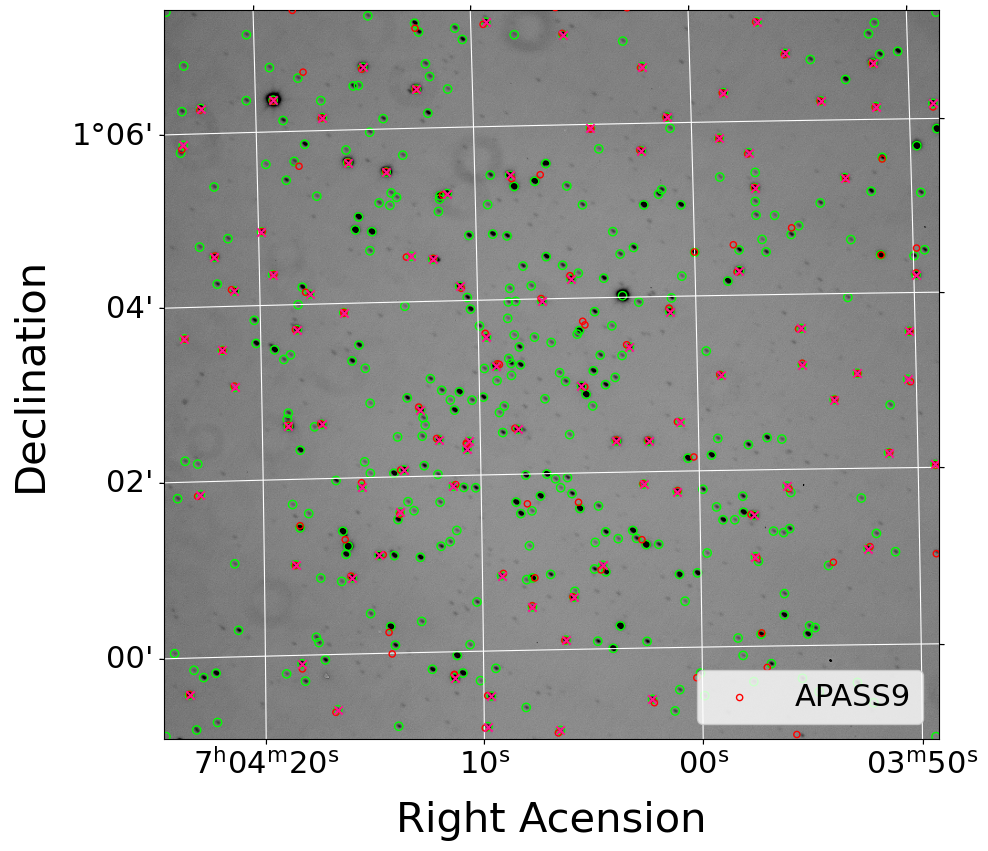

In [220]:
pixel_coords_total = []

for idx in range(0, len(test_RA)): 
    pixel_coords = Pixel_conversion(test_RA[idx], test_DEC[idx], temp_file_name)
    pixel_coords_total.append(pixel_coords)

data = fits.getdata(temp_file_name)

hdu = fits.open(temp_file_name)[0]
wcs_proj = wcs.WCS(hdu.header)
plt.subplot(projection=wcs_proj)


plt.scatter(catalog_RA_pixel, catalog_DEC_pixel, facecolor = 'none', edgecolors='red', s = 20, zorder = 3, label = 'APASS9')

for obs_coord in tar:
    obs_RA = obs_coord.ra.degree; obs_DEC = obs_coord.dec.degree
    pixel_coords = Pixel_conversion(obs_RA, obs_DEC, temp_file_name)
    plt.scatter(*pixel_coords, facecolor = 'None', edgecolors = 'lime')

for idx in obs_index:
    obs_RA = tar[idx].ra.degree; obs_DEC = tar[idx].dec.degree
    pixel_coords = Pixel_conversion(obs_RA, obs_DEC, temp_file_name)
    plt.scatter(*pixel_coords, marker = 'x', color = 'deeppink', zorder = 4)


plt.imshow(data, vmin = data.mean() - data.std(), vmax = data.mean() + data.std(), cmap = 'gist_yarg', zorder = 0)
plt.grid(color='white', ls='solid')
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('Right Acension'); plt.ylabel('Declination')
plt.show()

## Aperture Calibration 

In [267]:
from photutils import * 
from scipy.optimize import curve_fit
import pandas as pd

In [222]:
def aper_photometry(data, sources):
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

    # Aperture and Annulus 
    aperture = CircularAperture(positions, r=6)
    annulus_aperture = CircularAnnulus(positions, r_in = 10, r_out = 15)
    apers = (aperture, annulus_aperture)

    phot_table = aperture_photometry(data, apers)

    # We calculate the mean counts in each pixel in the background annulus, and the n multiply by the area
    # in the aperture to get the total background counts within each aperture 
    bkg_mean = phot_table['aperture_sum_1']/annulus_aperture.area
    bkg_sum = bkg_mean*aperture.area

    # # Now we get the final table of background subtracted counts within each aperture
    final_sum = phot_table['aperture_sum_0'] - bkg_sum

    return -2.5*np.log10(final_sum)

## Linear Fitting

In [223]:
def lin_func(x, m, c):
	return m*x + c

0.02431670750897492 0.25800602962296226
      params  param_err
0   0.970199   0.024317
1  24.032010   0.258006


Text(0, 0.5, 'Real Magnitude, $V_{real.}$')

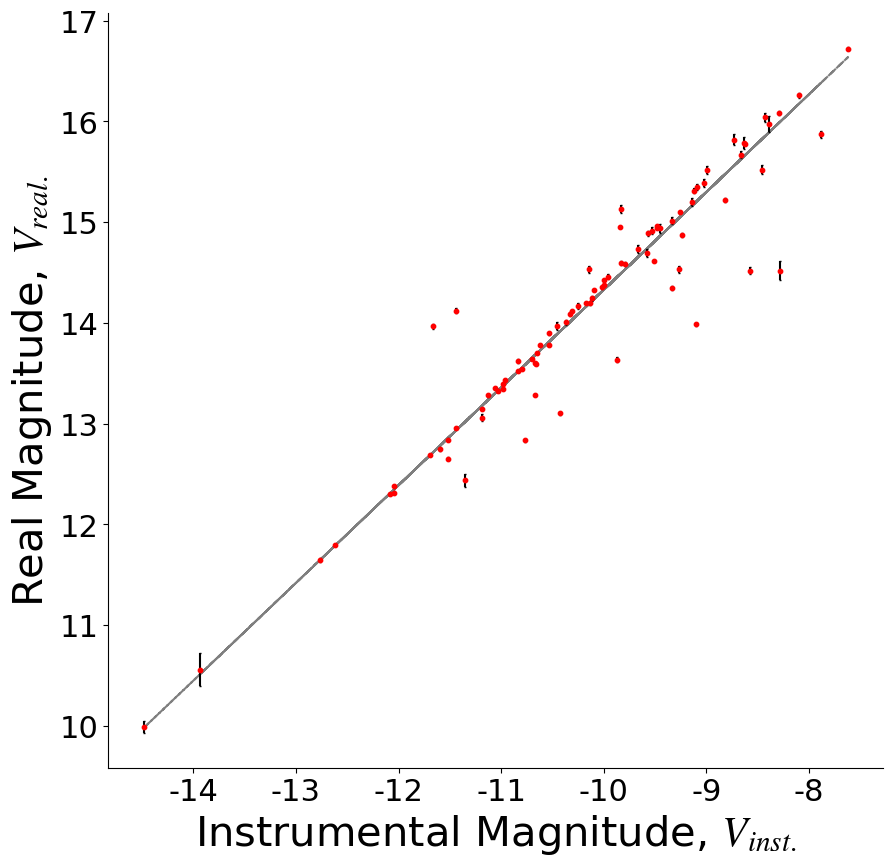

In [276]:
obs_mag = aper_photometry(image_data, DAO_source_table[obs_index])
catalog_mag = catalog_result['Vmag'][cat_index]; catalog_mag_err = catalog_result['e_Vmag'][cat_index]

# --- fitting data for graph --- 
popt, pcov = curve_fit(lin_func, obs_mag, catalog_mag, sigma = (catalog_mag_err))
fit_data = lin_func(obs_mag, popt[0], popt[1])
slope_err = np.sqrt(pcov[0][0]); const_err = np.sqrt(pcov[1][1])
print(slope_err, const_err)

# Create DataFrame   
data = {'params': popt, 'param_err': [slope_err, const_err]}  
df = pd.DataFrame(data)  
df.to_csv(r'calibration_parameters/' + target_name + '.txt', index=None, sep=' ', mode='a')
print(df)

plt.plot(obs_mag, fit_data, 'k--', alpha = 0.5)
plt.scatter(obs_mag, catalog_mag, s = 10, color = 'red', zorder = 3)
plt.errorbar(obs_mag, catalog_mag, yerr=catalog_mag_err, ls = 'None', capsize = .5, color = 'black')
plt.xlabel('Instrumental Magnitude, $V_{inst.}$'); plt.ylabel('Real Magnitude, $V_{real.}$')
